Fit interpretable models to the training set and test on validation sets.

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pickle as pkl
from os.path import join as oj
from io import StringIO
from IPython.display import Image

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
import pydotplus
#from dtreeviz.trees import dtreeviz - not loaded...

import imodels
import sys
#sys.path.append('../../../../')
from rulevetting.api import validation
from rulevetting.projects.tbi_pecarn.dataset import Dataset

MODELS_DIR = './models'
os.makedirs(MODELS_DIR, exist_ok=True)

outcome_def = 'outcome'  # output
data_path = '../../../../data/' # path to raw csv - change to processed...

C:\Users\hyunsuk\Anaconda3\lib\site-packages\redis\connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
df = Dataset().clean_data(data_path = data_path)
df = Dataset().preprocess_data(df)
df_train, df_tune, _ = Dataset().split_data(df)
X_train = df_train.drop(columns=outcome_def)
y_train = df_train[outcome_def].values
X_tune = df_tune.drop(columns=outcome_def)
y_tune = df_tune[outcome_def].values
processed_feats = df_train.keys().values.tolist()
feature_names = list(X_train)


def predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_tune],
                            [y_train, y_tune],
                            ['_train', '_tune']):
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))
    return stats, threshes

Reading the raw CSVs... ['TBI PUD 10-08-2013.csv', 'TBI PUD Imaging.csv', 'TBI PUD Neuro.csv']


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  6.52s/it]
C:\Users\hyunsuk\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [27]:
simple_var_list = ['InjuryMech_Assault',
       'InjuryMech_Bicyclist struck by automobile',
       'InjuryMech_Bike collision/fall', 'InjuryMech_Fall down stairs',
       'InjuryMech_Fall from an elevation',
       'InjuryMech_Fall to ground standing/walking/running',
       'InjuryMech_Motor vehicle collision',
       'InjuryMech_Object struck head - accidental',
       'InjuryMech_Other mechanism', 'InjuryMech_Other wheeled crash',
       'InjuryMech_Pedestrian struck by moving vehicle', 'InjuryMech_Sports',
       'InjuryMech_Walked/ran into stationary object',
       'High_impact_InjSev_High', 'High_impact_InjSev_Low',
       'High_impact_InjSev_Moderate', 'High_impact_InjSev_No', 'Amnesia_verb_No', 
       'Amnesia_verb_Pre/Non-verbal', 'Amnesia_verb_Yes',
       'LOCSeparate_No', 'LOCSeparate_Suspected', 'LOCSeparate_Yes', 
       'Seiz', 'ActNorm', 'HA_verb_No', 'HA_verb_Pre/Non-verbal', 'HA_verb_Yes',
        'Vomit', 'Intubated', 'Paralyzed', 'Sedated',
       'GCSTotal', 'GCSGroup', 'AMS', 'SFxPalp_No', 'SFxPalp_Unclear', 'SFxPalp_Yes',
       'FontBulg', 'Hema', 'Clav', 'NeuroD', 'OSI', 'Drugs', 'AgeTwoPlus', 'Gender', 'outcome']

df_simp = df[simple_var_list]

# Excluding samples with GCS score < 14
df_simp = df[simple_var_list + ["GCSGroup"]]
df_simp = df_simp.loc[df_simp["GCSGroup"] != 1]
df_simp = df_simp.drop(columns=["GCSGroup"])

# TRAIN AND TEST FROM SIMPLIFIED DATA 
df_simp_train, df_simp_tune, df_simp_test = Dataset().split_data(df_simp)
X_simp_train = df_simp_train.drop(columns=outcome_def)
y_simp_train = df_simp_train[outcome_def].values
X_simp_tune = df_simp_tune.drop(columns=outcome_def)
y_simp_tune = df_simp_tune[outcome_def].values
X_simp_test = df_simp_test.drop(columns=outcome_def)
y_simp_test = df_simp_test[outcome_def].values
processed_feats_simp = df_simp_train.keys().values.tolist()
feature_names_simp = list(X_simp_train)


In [14]:
# SANITY CHECK
# df_simp.iloc[0, :]

# fit simple models

**decision tree**

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 614.57it/s]


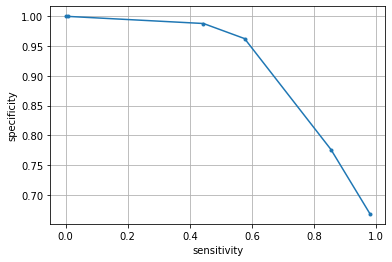

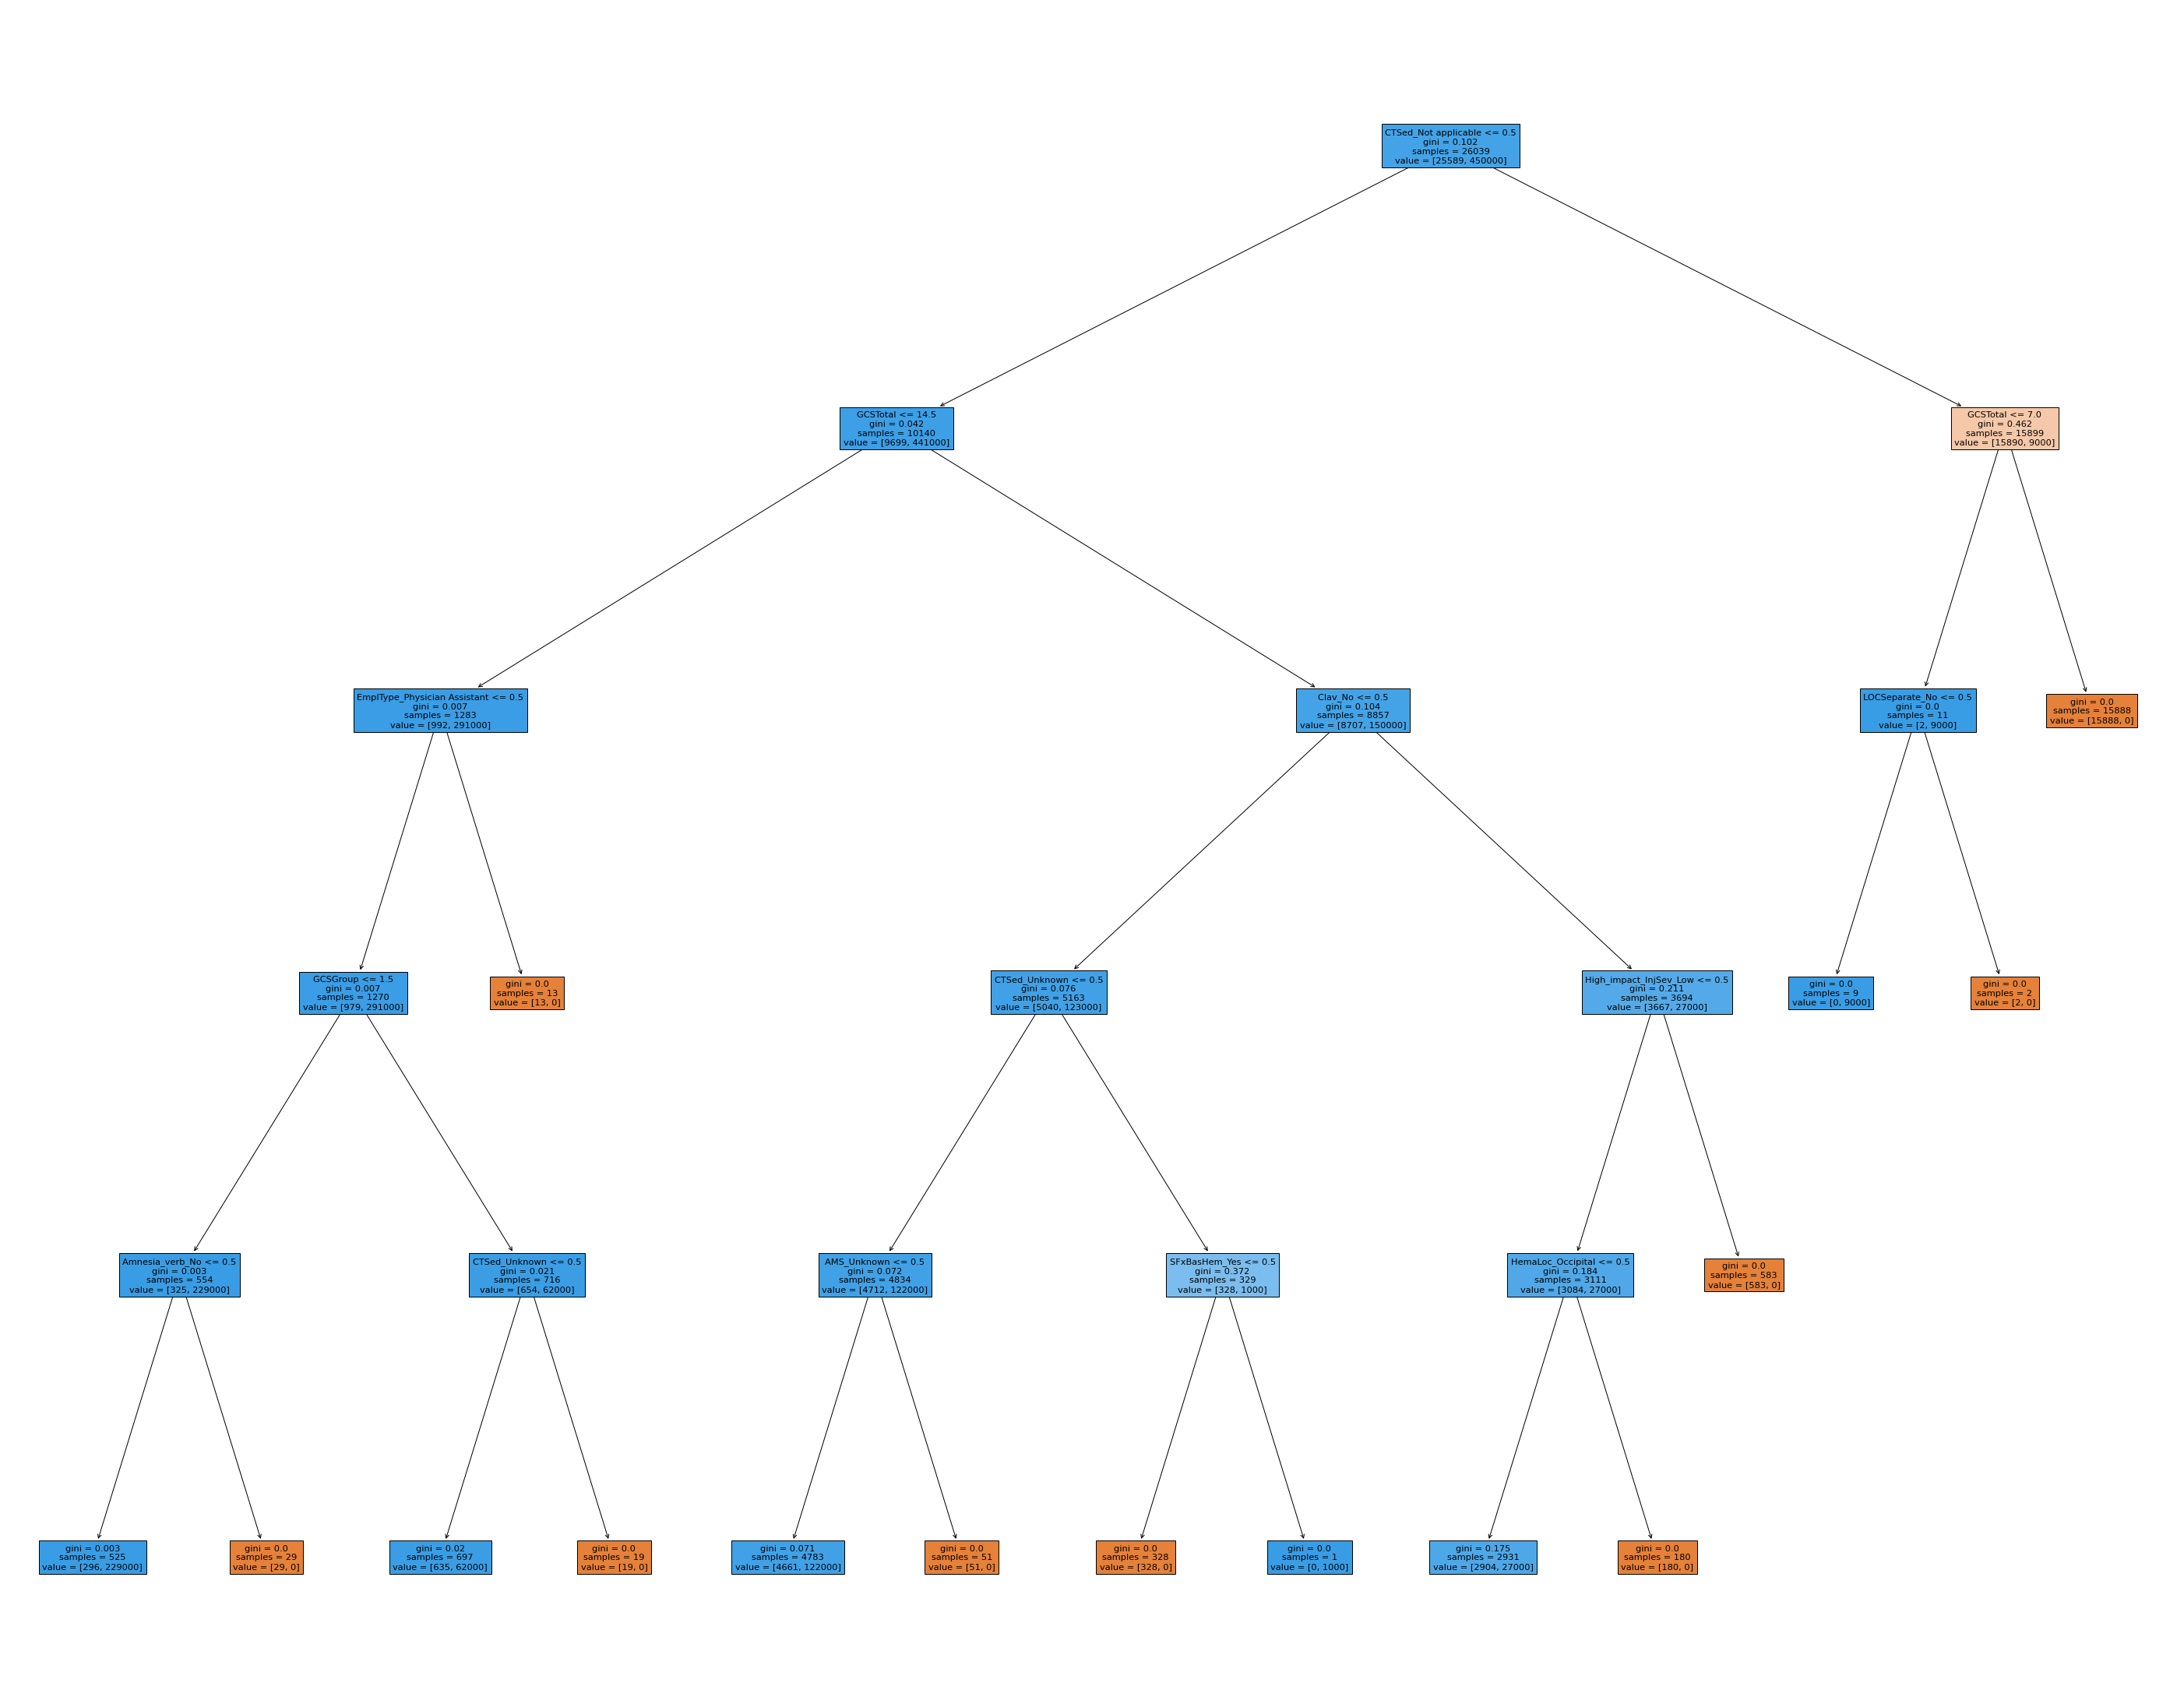

In [4]:
# fit decition tree
dt = DecisionTreeClassifier(max_depth=5, class_weight={0: 1, 1: 1e3})
dt.fit(X_train, y_train)
stats, threshes = predict_and_save(dt, model_name='decision_tree')
plt.show()

fig = plt.figure(figsize=(50, 40))
plot_tree(dt, feature_names=feature_names, filled=True)
plt.show()

In [9]:
print('Feature Importances:\n')
for col, val in sorted(zip(X_train.columns, dt.feature_importances_), key=lambda x: x[1], reverse=True)[:10]:
    print(f'{col:10}{val:10.3f}')
    
print('\nTest Score:\n')
print(dt.score(X_tune, y_tune))

Feature Importances:

CTSed_Not applicable     0.555
GCSTotal       0.372
High_impact_InjSev_Low     0.028
SFxBasHem_Yes     0.015
Clav_No        0.010
HemaLoc_Occipital     0.009
CTSed_Unknown     0.005
AMS_Unknown     0.003
Amnesia_verb_No     0.002
EmplType_Physician Assistant     0.001

Test Score:

0.6736175115207373


Well uhhh, I think I need to return to cleaning to see what's going on - GCSTotal is overwhelming  categorical vars solely due to the fact that it is sort of continous. I'll return to cleaning the data as I think I messed up there...

**bayesian rule list (this one is slow)**

In [14]:
np.random.seed(13)
# train classifier (allow more iterations for better accuracy; use BigDataRuleListClassifier for large datasets)
print('training bayesian_rule_list...')
brl = imodels.BayesianRuleListClassifier(listlengthprior=2, max_iter=10000, class1label="IwI", verbose=False)
brl.fit(X_train, y_train, feature_names=feature_names)
stats, threshes = predict_and_save(brl, model_name='bayesian_rule_list')
print(brl)

training bayesian_rule_list...


KeyboardInterrupt: 

In [47]:
print(brl)

(Untrained RuleListClassifier)


**rulefit**

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 1482.71it/s]


'\ndef print_best(sens, spec):\n    idxs = np.array(sens) > 0.9\n    print(np.array(sens)[idxs], np.array(spec)[idxs])\nprint_best(sens, spec)\n'

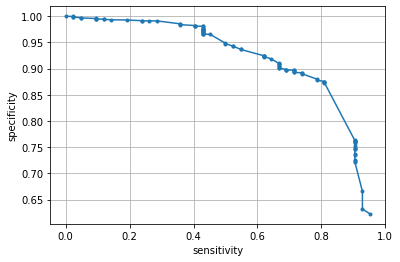

In [15]:
# fit a rulefit model
np.random.seed(13)
rulefit = imodels.RuleFitRegressor(max_rules=4)
rulefit.fit(X_train, y_train, feature_names=feature_names)

# preds = rulefit.predict(X_test)
stats, threshes = predict_and_save(rulefit, model_name='rulefit')
'''
def print_best(sens, spec):
    idxs = np.array(sens) > 0.9
    print(np.array(sens)[idxs], np.array(spec)[idxs])
print_best(sens, spec)
'''

In [20]:
# pd.reset_option('display.max_colwidth')
rulefit.visualize()

,rule,coef
10,AbdTrauma_no,-0.01
11,AbdTrauma_or_SeatBeltSign_no,-0.02
12,AbdTrauma_or_SeatBeltSign_yes,0.00
29,GCSScore,-0.01
55,VomitWretch_no,-0.00
59,DecrBreathSound_yes <= 0.5 and AbdDistention_yes <= 0.5,-0.01
60,AbdDistention_yes <= 0.5 and AbdTenderDegree_Severe <= 0.5,-0.07
58,GCSScore > 9.5 and AbdTenderDegree_Severe <= 0.5,-0.01
61,VomitWretch_no > 0.5,-0.00


**greedy (CART) rule list**

/Users/chandan/venvs/rule-vetting/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/chandan/venvs/rule-vetting/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1109.18it/s]

mean 0.016 (7226 pts)
if AbdDistention >= 1.0 then 0.175 (166 pts)
mean 0.012 (7060 pts)
if feat 8 >= 1.0 then 0.121 (223 pts)
mean 0.009 (6837 pts)
if feat 50 >= 1.0 then 0.044 (615 pts)
mean 0.005 (6222 pts)
if feat 46 >= 1.0 then 0.029 (307 pts)
mean 0.004 (5915 pts)
if feat 6 >= 1.0 then 0.012 (805 pts)
mean 0.003 (5110 pts)
if feat 43 >= 3.0 then 0.02 (101 pts)
mean 0.002 (5009 pts)
if feat 18 >= 17.0 then 0.009 (459 pts)
mean 0.002 (4550 pts)
if feat 33 >= 1.0 then 0.024 (42 pts)
mean 0.001 (4508 pts)
if feat 35 >= 1.0 then 0.007 (302 pts)



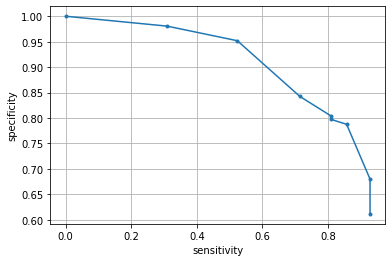

In [24]:
class_weight = {0: 1, 1: 100}
d = imodels.GreedyRuleListClassifier(max_depth=9, class_weight=class_weight, criterion='neg_corr')
d.fit(X_train, y_train, feature_names=feature_names, verbose=False)
stats, threshes = predict_and_save(d, model_name='grl')
# d.print_list()
print(d)

**rf**

In [25]:
# # specify a decision tree with a maximum depth
# rf = RandomForestClassifier()
# rf.fit(X_train, y_train)
# sens, spec, threshes = predict_and_save(rf, model_name='rf')
# # sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, preds_proba[:, 1])
# imps = rf.feature_importances_.round(3)
# args = np.argsort(imps)
# imps = imps[args]
# feats = np.array(processed_feats)[args]
# for imp, feat in zip(imps, feats):
#     print(feat, imp)

# look at all the results

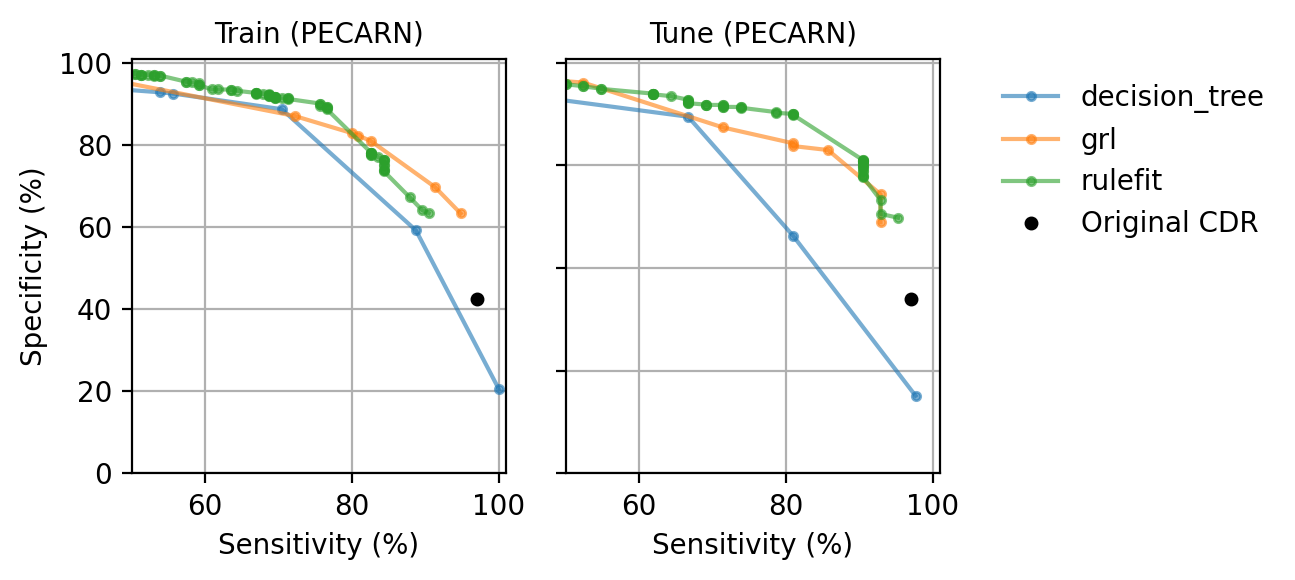

"x\nplt.figure(dpi=200, figsize=(C * 6, R * 6))\nfor i, suffix in enumerate(suffixes):\n    plt.subplot(R, C, i + 1)\n    plot_metrics(suffix, title=titles[i])\n    plt.xlim((80, 101))\n    plt.ylim((25, 70))\nplt.subplot(R, C, 1)    \nplt.legend()\nplt.tight_layout()\nviz.savefig('metrics_3_splits_zoom')\nplt.show()\nplt.legend(bbox_to_anchor=(1.05, 1.05))\n"

In [31]:
def plot_metrics(suffix, title=None, fs=15):
    for fname in sorted(os.listdir(MODELS_DIR)):
        if 'pkl' in fname:
            if not fname[:-4] == 'rf':
                r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
                #         print(r)
                #                 print(r.keys())

                threshes = np.array(r['threshes' + suffix])
                sens = np.array(r['sens' + suffix])
                spec = np.array(r['spec' + suffix])
                plt.plot(100 * sens, 100 * spec, 'o-', label=fname[:-4], alpha=0.6, markersize=3)
                plt.xlabel('Sensitivity (%)', fontsize=fs)
                plt.ylabel('Specificity (%)', fontsize=fs)
                s = suffix[1:]
                if title is None:
                    plt.title(f'{s}\n{data_sizes[s][0]} IAI-I / {data_sizes[s][1]}')
                else:
                    plt.title(title, fontsize=fs)

                # print best results
                if suffix == '_test2':
                    idxs = (sens > 0.95) & (spec > 0.43)
                    if np.sum(idxs) > 0:
                        idx_max = np.argmax(spec[idxs])
                        print(fname, f'{100 * sens[idxs][idx_max]:0.2f} {100 * spec[idxs][idx_max]:0.2f}')

    if suffix == '_test2':
        plt.plot(96.77, 43.98, 'o', color='black', label='Original CDR', ms=4)
    else:
        plt.plot(97.0, 42.5, 'o', color='black', label='Original CDR', ms=4)
    plt.grid()


suffixes = ['_train', '_tune']  # _train, _test1, _test2, _cv
titles = ['Train (PECARN)', 'Tune (PECARN)']
R, C = 1, len(suffixes)
plt.figure(dpi=200, figsize=(C * 2.5, R * 3), facecolor='w')
fs = 10
for i, suffix in enumerate(suffixes):
    ax = plt.subplot(R, C, i + 1)
    plot_metrics(suffix, title=titles[i], fs=fs)
    if i > 0:
        plt.ylabel('')
        plt.yticks([0, 25, 50, 75, 100], labels=[''] * 5)
    #         ax.yaxis.set_visible(False)
    plt.xlim((50, 101))
    plt.ylim((0, 101))
plt.tight_layout()
# plt.subplot(R, C, 1)
# plt.legend(fontsize=20)
plt.legend(bbox_to_anchor=(1.1, 1), fontsize=fs, frameon=False)
plt.savefig('figs/metrics_3_splits')
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 1591.61it/s]


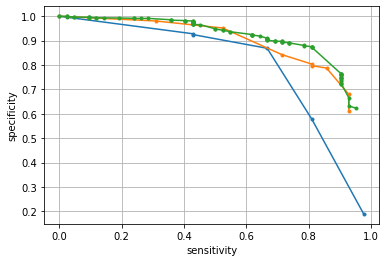

In [37]:
def print_metrics(suffix):
    vals = {s: [] for s in ['sens', 'spec', 'ppv', 'npv', 'lr+', 'lr-', 'brier_score', 'f1']}
    fnames = []
    for fname in sorted(os.listdir(MODELS_DIR)):
        if 'pkl' in fname:
            if not fname[:-4] == 'rf':
                r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
                threshes = np.array(r['threshes' + suffix])
                m = r['model']

                # add more stats
                for x, y, suff in zip([X_train, X_tune],
                                      [y_train, y_tune],
                                      ['_train', '_tune']):
                    if suff == suffix:
                        stats, threshes = validation.all_stats_curve(y, m.predict_proba(x)[:, 1],
                                                                     plot=suffix == '_tune')
                        preds_proba = m.predict_proba(x)[:, 1]
                        brier_score = metrics.brier_score_loss(y, preds_proba)

                # pick best vals
                sens = np.array(r['sens' + suffix])
                spec = np.array(r['spec' + suffix])
                best_idx = np.argmax(5 * sens + spec)
                for k in vals.keys():
                    if not k == 'brier_score':
                        #                         print('k', k)
                        vals[k].append(stats[k][best_idx])
                vals['brier_score'].append(brier_score)
                fnames.append(fname[:-4])
    stats = pd.DataFrame.from_dict(vals)
    stats.index = fnames
    return (stats).round(2).transpose()


suffixes = ['_train', '_tune']  # _train, _test1, _test2
stats_list = {}
for i, suffix in enumerate(suffixes):
    stats_list[suffix] = print_metrics(suffix)

In [38]:
stats_list['_train']

,decision_tree,grl,rulefit
sens,1.00,0.95,0.90
spec,0.20,0.63,0.63
ppv,0.02,0.04,0.04
npv,1.00,1.00,1.00
lr+,1.26,2.58,2.47
lr-,0.00,0.08,0.15
brier_score,0.61,0.01,0.08
f1,0.04,0.08,0.07


In [39]:
stats_list['_tune']

,decision_tree,grl,rulefit
sens,0.98,0.93,0.95
spec,0.19,0.68,0.62
ppv,0.02,0.05,0.04
npv,1.00,1.00,1.00
lr+,1.20,2.90,2.52
lr-,0.13,0.11,0.08
brier_score,0.62,0.02,0.08
f1,0.04,0.09,0.08


## Logistic regression on df_simp

0.9445143762373942
0.9858294930875576


100%|█████████████████████████████████████████████████████████████████████████████| 3715/3715 [00:08<00:00, 426.18it/s]


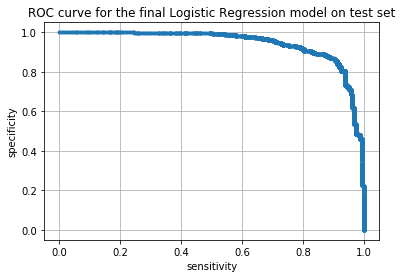

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

X_simp_train = df_simp_train.drop(columns=outcome_def)
y_simp_train = df_simp_train[outcome_def].values
X_simp_tune = df_simp_tune.drop(columns=outcome_def)
y_simp_tune = df_simp_tune[outcome_def].values

processed_feats_simp = df_simp_train.keys().values.tolist()
feature_names_simp = list(X_simp_train)


# Now fitting logistic regression (Demo)
logreg_model = LogisticRegression(solver='liblinear', random_state = 0).fit(X_simp_train, y_simp_train)
roc_auc_score(y_simp_train, logreg_model.predict_proba(X_simp_train)[:, 1])  # Train AUC : 0.9513

# Tuning logistic regression
roc_tune = []
acc_tune = []
for lamb in [0.001, 0.01, 0.1, 1, 2, 5, 10] :
    logreg_model = LogisticRegression(solver='liblinear', random_state = 0, C = lamb).fit(X_simp_train, y_simp_train)
    roc_tune.append(roc_auc_score(y_simp_tune, logreg_model.predict_proba(X_simp_tune)[:, 1]))
    acc_tune.append(logreg_model.score(X_simp_tune, y_simp_tune))
np.around(roc_tune, 5) # [0.90894, 0.91271, 0.91609, 0.91635, 0.91627, 0.91622, 0.91627]
np.around(acc_tune, 5) # [0.98376, 0.98629, 0.9871 , 0.98687, 0.98687, 0.98687, 0.98687]


# Using 1 as final regularization
logreg_model = LogisticRegression(solver='liblinear', random_state = 0, C = lamb).fit(pd.concat([X_simp_train, X_simp_tune], axis = 0), 
                                                                                      np.hstack((y_simp_train, y_simp_tune)))
print(roc_auc_score(y_simp_test, logreg_model.predict_proba(X_simp_test)[:, 1]))  # 0.94451
print(logreg_model.score(X_simp_test, y_simp_test))  # 0.98583

# Plot the result for the test set
validation.all_stats_curve(y_simp_test, logreg_model.predict_proba(X_simp_test)[:, 1], plot = True)
plt.title('ROC curve for the final Logistic Regression model on test set')
plt.show()